In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from scipy.optimize import fmin_l_bfgs_b

In [0]:
#for image path setup
from PIL import Image
import requests
from io import BytesIO

In [0]:
content_path='input.png'
style_path='style.png'
combined_path='combined.png'

input_style='https://cdn.britannica.com/s:500x350/78/43678-004-8F18BDDF.jpg'
input_content='https://www.telegraph.co.uk/content/dam/Travel/Destinations/Europe/Spain/Barcelona/barcelona-parc-guell-cityscape.jpg?imwidth=450'
img_width=500
img_height=500

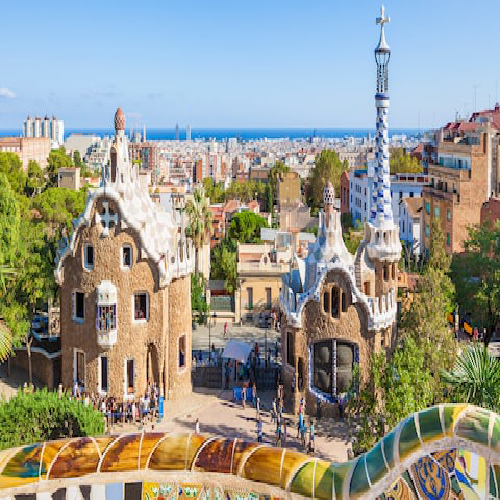

In [95]:
#input
input_image = Image.open(BytesIO(requests.get(input_content).content))
input_image = input_image.resize((img_width,img_height))
input_image.save(content_path)
input_image

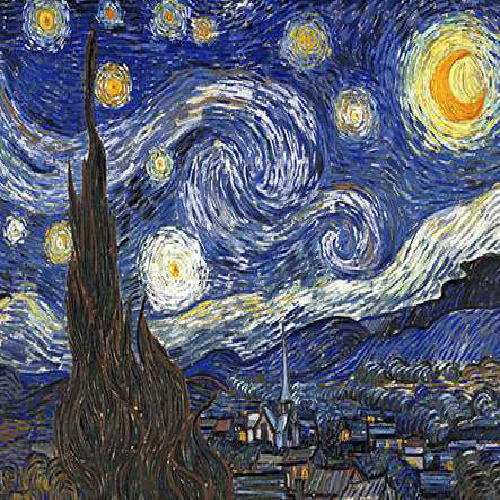

In [96]:
#style
style_img=Image.open(BytesIO(requests.get(input_style).content))
style_img=style_img.resize((img_width,img_height))
style_img.save(style_path)
style_img

In [0]:
from keras.applications import vgg19
from keras.preprocessing.image import load_img,img_to_array

In [0]:
def preprocess_image(image_path):
  img=load_img(image_path,target_size=(img_height,img_width))
  img=img_to_array(img)
  img=np.expand_dims(img,axis=0)
  img=vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(x):
  x=x[:,:,::-1]
  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68
  
  x=np.click(x,0,255).astype("uint8")
  return x

In [0]:
from keras import backend as K
target_image=K.constant(preprocess_image(content_path))
style_image=K.constant(preprocess_image(style_path))
combination_image=K.placeholder((1,img_height,img_width,3))
input_tensor=K.concatenate([target_image,style_image,combination_image],axis=0)

model=vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)

In [0]:
def content_loss(base,combination):
  return K.sum(K.square(combination-base))

In [0]:
def gram_matrix(x):
  features=K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
  gram=K.dot(features,K.transpose(features))
  return gram

In [0]:

def style_loss(style,combination):
  S=gram_matrix(style)
  C=gram_matrix(combination)
  channels=3
  size=img_height*img_width
  return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
  a = K.square(
  x[:, :img_height - 1, :img_width - 1, :] -
  x[:, 1:, :img_width - 1, :])
  b = K.square(
  x[:, :img_height - 1, :img_width - 1, :] -
  x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
total_variation_weight = 0.994
style_weight = 1.
content_weight = 0.025

In [106]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
combination_features)
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

W0617 16:23:10.885932 140305933727616 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator=Evaluator()

Iteration 0 completed with loss 7731115520
Iteration 1 completed with loss 5724967936
Iteration 2 completed with loss 5084549632
Iteration 3 completed with loss 4795214336
Iteration 4 completed with loss 4636364288
Iteration 5 completed with loss 4530588672
Iteration 6 completed with loss 4462850560
Iteration 7 completed with loss 4394403328


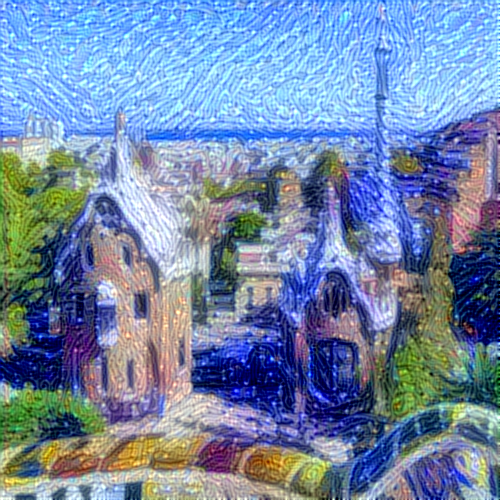

In [108]:

iterations = 8
x = preprocess_image(content_path)

for i in range(iterations):
  x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
  print("Iteration %d completed with loss %d" % (i, loss))
    
  
x = x.reshape((img_height, img_width, 3))
#img = deprocess_image(img)
  #fname = result_prefix + '_at_iteration_%d.png' % i
  #imsave(fname, img)
  #print('Image saved as', fname)
  #end_time = time.time()
  #print('Iteration %d completed in %ds' % (i, end_time - start_time))
x = x[:, :, ::-1]
x[:, :, 0] +=103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(combined_path)
output_image 
  

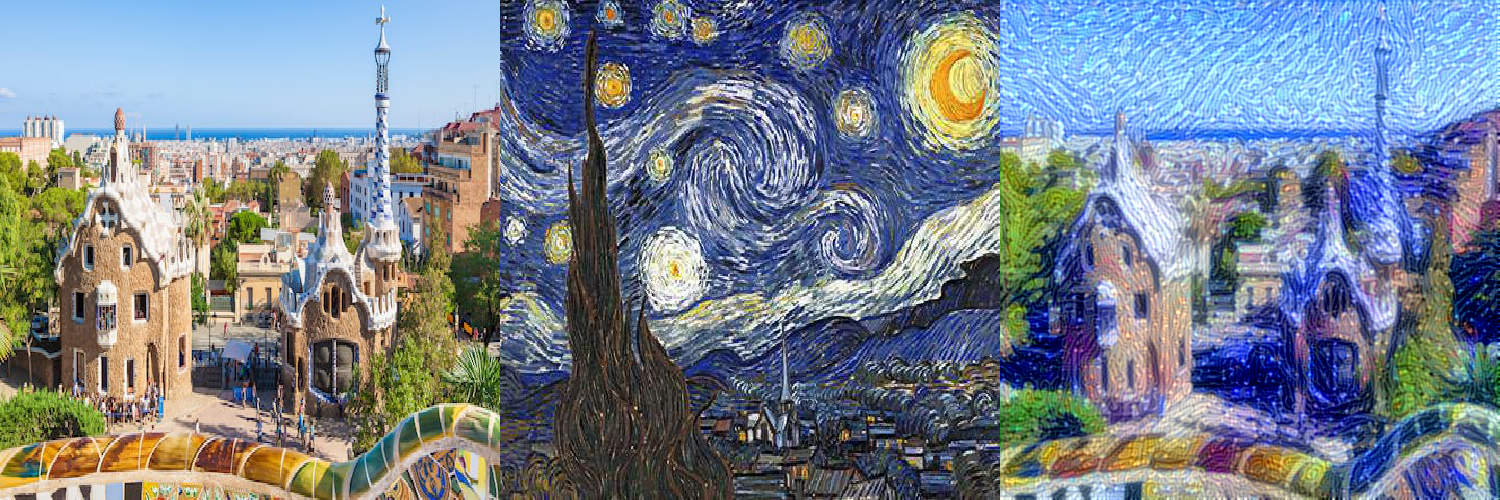

In [109]:
combined_image_path='combined.png'
combined = Image.new("RGB", (img_width*3, img_height))
x_offset = 0
for image in map(Image.open, [content_path, style_path, combined_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += img_width
combined.save(combined_image_path)
combined